[Original Source](https://www.philschmid.de/fine-tuning-lilt)

# Document AI: LiLT a better language agnostic LayoutLM model

In this blog, you will learn how to fine-tune LiLt for document-understand using Hugging Face Transformers. 
LiLt or Language independent Layout Transformer can combine any pre-trained RoBERTa text encoder with a 
lightweight Layout Transformer, to enable document understanding and information extraction for any language. 
This means you can use non-English RoBERTa checkpoints, e.g. bertin-project/bertin-roberta-base-spanish for 
document understanding tasks. To convert a RoBERTa checkpoint to a LiLT checkpoint, you can follow this guide.
LiLt is released with an MIT license and is available on the Hugging Face Hub.

In this example we will use the FUNSD dataset a collection of 199 fully annotated forms. More information 
for the dataset can be found at the dataset page.

You will learn how to:

- [Setup Development Environment](https://www.philschmid.de/fine-tuning-lilt#1-setup-development-environment)
- [Load and prepare FUNSD dataset](https://www.philschmid.de/fine-tuning-lilt#2-load-and-prepare-funsd-dataset)
- [Fine-tune and evaluate LiLT](https://www.philschmid.de/fine-tuning-lilt#3-fine-tune-and-evaluate-lilt)
- [Run Inference](https://www.philschmid.de/fine-tuning-lilt#4-run-inference)

Before we can start, make sure you have a Hugging Face Account to save artifacts and experiments.

## Quick intro: LiLT Language-independent Layout Transformer

LiLT is a language independent Transformer model for document image understanding and information extraction
transformers and can be used form understanding and receipt understanding. LiLT can be pretrained on the 
structured documents of a single language and then directly fine-tuned on other languages with the corresponding 
offthe-shelf monolingual/multilingual pre-trained textual models.      

![](https://www.philschmid.de/static/blog/fine-tuning-lilt/lilt.png)
- [LiLT: A Simple yet Effective Language-Independent Layout Transformer for Structured Document Understanding](https://arxiv.org/abs/2202.13669)
- https://github.com/jpwang/lilt
                
Now we know how LiLT works, let's get started. 🚀

Note: This tutorial was created and run on a g4dn.xlarge AWS EC2 Instance including a NVIDIA T4.

## 1. Setup Development Environment

Our first step is to install the Hugging Face Libraries, including transformers and datasets. Running the following 
cell will install all the required packages. Additinoally, we need to install an OCR-library to extract text from 
images. We will use [pytesseract](https://pypi.org/project/pytesseract/).

In [1]:
!apt update
!apt install -y nodejs npm
!apt install -y tesseract-ocr
!apt-get install git-lfs --yes

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease  
Fetched 257 kB in 1s (229 kB/s)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
18 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  adwaita-icon-theme at-spi2-core dbus-user-session dconf-gsettings-backend
  dconf-service gsettings-desktop-schemas gtk-update-icon-cache gyp
  hicolor-icon-theme humanity-icon-theme javascript-common libatk-bridge2.0-0
  libatk1.0-0 libatk1.0-data libatspi2.0-0 libauthen-sasl-perl
  liba

In [2]:
!pip install pytesseract transformers datasets seqeval tensorboard evaluate --upgrade
# install git-fls for pushing model and logs to the hugging face hub
!pip install ipywidgets
!python3 -m pip install --upgrade pip
!pip install --upgrade transformers
!pip install tf-keras
!pip install accelerate
!pip install transformers[torch]

  Preparing metadata (setup.py) ... one
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.1/40.1 MB 22.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 25.4 MB/s eta 0:00:00 0:00:01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=120da26f6baca01628c85effc9b7c2ff558d9833ae484bf0d8735f4cb254fd51
  Stored in directory: /root/.cache/pip/wheels/bc/92/f0/243288f899c2eacdfa8c5f9aede4c71a9bad0ee26a01dc5ead
Successfully built seqeval
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 7.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.3 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.4/615.4 MB 15.6 MB/s eta 0:00:0000:0100

In [3]:
# CPU
# !pip install torch torchvision torchaudio

#CUDA
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Looking in indexes: https://download.pytorch.org/whl/cu118


This example will use the [Hugging Face Hub](https://huggingface.co/models) as a remote model versioning service. 
To be able to push our model to the Hub, you need to register on the Hugging Face. If you already have an account, 
you can skip this step. After you have an account, we will use the notebook_login util from the huggingface_hub 
package to log into our account and store our token (access key) on the disk.

In [4]:
from huggingface_hub import notebook_login
notebook_login()

## 2. Load and prepare FUNSD dataset

We will use the [FUNSD](https://guillaumejaume.github.io/FUNSD/) dataset a collection of 199 fully annotated forms. 
The dataset is available on Hugging Face at [nielsr/funsd](https://huggingface.co/datasets/nielsr/funsd) and 
[nielsr/funsd-layoutlmv3](https://huggingface.co/datasets/nielsr/funsd-layoutlmv3). We will use the `nielsr/funsd-layoutlmv3`, 
which includes segment positions, which will help in boosting the performance (as shown in [this paper](https://arxiv.org/abs/2105.11210)).

In [5]:
#dataset_id ="nielsr/funsd"
dataset_id ="nielsr/funsd-layoutlmv3"

To load the `funsd` dataset, we use the `load_dataset()` method from the 🤗 Datasets library.

In [6]:
from datasets import load_dataset
 
dataset = load_dataset(dataset_id)
 
print(f"Train dataset size: {len(dataset['train'])}")
print(f"Test dataset size: {len(dataset['test'])}")
# Train dataset size: 149
# Test dataset size: 50

funsd-layoutlmv3.py:   0%|          | 0.00/5.13k [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/26.3M [00:00<?, ?B/s]

0000.parquet:   0%|          | 0.00/9.54M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/149 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/50 [00:00<?, ? examples/s]

Train dataset size: 149
Test dataset size: 50


Lets checkout an example of the dataset.

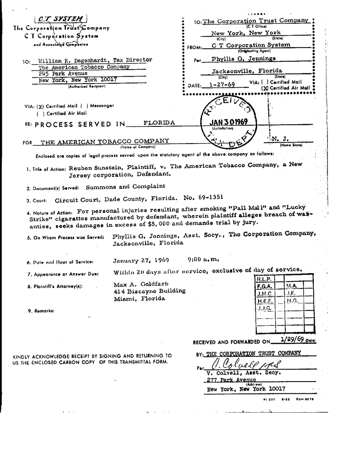

In [7]:
from PIL import Image, ImageDraw, ImageFont
 
image = dataset['train'][34]['image']
image = image.convert("RGB")
image.resize((350,450))

We can display all our classes by inspecting the features of our dataset. Those `ner_tags` will be later used to
create a user friendly output after we fine-tuned our model.

In [8]:
labels = dataset['train'].features['ner_tags'].feature.names
print(f"Available labels: {labels}")
 
id2label = {v: k for v, k in enumerate(labels)}
label2id = {k: v for v, k in enumerate(labels)}
#    Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']

Available labels: ['O', 'B-HEADER', 'I-HEADER', 'B-QUESTION', 'I-QUESTION', 'B-ANSWER', 'I-ANSWER']


To train our model we need to convert our inputs (text/image) to token IDs. This is done by a 🤗 Transformers 
Tokenizer and PyTesseract. If you are not sure what this means check out [chapter 6](https://huggingface.co/course/chapter6/1?fw=tf)
of the Hugging Face Course.

Note: The LiLT model doesn't have a `AutoProcessor` or `Tokenizer` to nicely create our input documents, but we 
can use the `LayoutLMv3Processor` or `LayoutLMv2Processor` instead.

In [9]:
from transformers import LayoutLMv3ImageProcessor, LayoutLMv3FeatureExtractor, AutoTokenizer, LayoutLMv3Processor
 
model_id="SCUT-DLVCLab/lilt-roberta-en-base"
 
## use LayoutLMv3 processor without ocr since the dataset already includes the ocr text
#feature_extractor = LayoutLMv3FeatureExtractor(apply_ocr=False) # set
#tokenizer = AutoTokenizer.from_pretrained(model_id)
## cannot use from_pretrained since the processor is not saved in the base model
#processor = LayoutLMv3Processor(feature_extractor, tokenizer)

image_processor = LayoutLMv3ImageProcessor(apply_ocr=False)  # Updated class
tokenizer = AutoTokenizer.from_pretrained(model_id)
# Create the processor
processor = LayoutLMv3Processor(image_processor, tokenizer)


2025-01-15 21:11:10.511763: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-15 21:11:10.519034: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736975470.527895    1200 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736975470.531460    1200 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-15 21:11:10.541158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

tokenizer_config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/957 [00:00<?, ?B/s]

Before we can process our dataset we need to define the `features` or the processed inputs, which are later based 
into the model. Features are a special dictionary that defines the internal structure of a dataset. Compared to 
traditional NLP datasets we need to add the `bbox` feature, which is a 2D array of the bounding boxes for each token.

In [10]:
from PIL import Image
from functools import partial
from datasets import Features, Sequence, ClassLabel, Value, Array2D
  
# we need to define custom features
features = Features(
    {
        "input_ids": Sequence(feature=Value(dtype="int64")),
        "attention_mask": Sequence(feature=Value(dtype="int64")),
        "bbox": Array2D(dtype="int64", shape=(512, 4)),
        "labels": Sequence(ClassLabel(names=labels)),
    }
)
 
# preprocess function to perpare into the correct format for the model
def process(sample, processor=None):
    encoding = processor(
        sample["image"].convert("RGB"),
        sample["tokens"],
        boxes=sample["bboxes"],
        word_labels=sample["ner_tags"],
        padding="max_length",
        truncation=True,
    )
    # remove pixel values not needed for LiLT
    del encoding["pixel_values"]
    return encoding 
 
# process the dataset and format it to pytorch
proc_dataset = dataset.map(
    partial(process, processor=processor),
    remove_columns=["image", "tokens", "ner_tags", "id", "bboxes"],
    features=features,
).with_format("torch")
 
print(proc_dataset["train"].features.keys())
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask', 'bbox','lables'])

Map:   0%|          | 0/149 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

dict_keys(['input_ids', 'attention_mask', 'bbox', 'labels'])


## 3. Fine-tune and evaluate LiLT

After we have processed our dataset, we can start training our model. Therefore we first need to load the 
[SCUT-DLVCLab/lilt-roberta-en-base](https://www.philschmid.de/SCUT-DLVCLab/lilt-roberta-en-base) model, 
which is based on a English RoBERTa model with the `LiltForTokenClassification` class with the label 
mapping of our dataset.

In [11]:
from transformers import LiltForTokenClassification
 
# huggingface hub model id
model_id = "SCUT-DLVCLab/lilt-roberta-en-base"
 
# load model with correct number of labels and mapping
model = LiltForTokenClassification.from_pretrained(
    model_id, num_labels=len(labels), label2id=label2id, id2label=id2label
)

config.json:   0%|          | 0.00/697 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/523M [00:00<?, ?B/s]

Some weights of LiltForTokenClassification were not initialized from the model checkpoint at SCUT-DLVCLab/lilt-roberta-en-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We want to evaluate our model during training. The `Trainer` supports evaluation during training by providing 
a `compute_metrics`. We are going to use `seqeval` and the `evaluate` library to evaluate the overall f1 score for all tokens.

In [12]:
import evaluate
import numpy as np
 
# load seqeval metric
metric = evaluate.load("seqeval")
 
# labels of the model
ner_labels = list(model.config.id2label.values())
 
 
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)
 
    all_predictions = []
    all_labels = []
    for prediction, label in zip(predictions, labels):
        for predicted_idx, label_idx in zip(prediction, label):
            if label_idx == -100:
                continue
            all_predictions.append(ner_labels[predicted_idx])
            all_labels.append(ner_labels[label_idx])
    return metric.compute(predictions=[all_predictions], references=[all_labels])

The last step is to define the hyperparameters (`TrainingArguments`) we want to use 
for our training. We are leveraging the [Hugging Face Hub](https://huggingface.co/models)
integration of the `Trainer` to automatically push our checkpoints, logs and metrics during 
training into a repository.

In [13]:
from huggingface_hub import HfFolder
from transformers import Trainer, TrainingArguments
 
# hugging face parameter
repository_id = "./model_outputs" #"lilt-en-funsd"
 
## Define training args
training_args = TrainingArguments(
    output_dir=repository_id,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    learning_rate=5e-5,
    max_steps=2500,
    # logging & evaluation strategies
    logging_dir=f"{repository_id}/logs",
    logging_steps=200,
    eval_strategy="steps",
    save_strategy="steps",
    save_steps=200,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="overall_f1",
    # push to hub parameters
    report_to="tensorboard",
#    push_to_hub=True,
#    hub_strategy="every_save",
#    hub_model_id=repository_id,
#    hub_token=HfFolder.get_token(),
)

# Create Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=proc_dataset["train"],
    eval_dataset=proc_dataset["test"],
    compute_metrics=compute_metrics,
)

We can start our training by using the `train` method of the `Trainer`.

In [14]:
# Start training
trainer.train()

Step,Training Loss,Validation Loss,Answer,Header,Question,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
200,0.409300,1.094917,"{'precision': 0.8215451577801959, 'recall': 0.9241126070991432, 'f1': 0.8698156682027651, 'number': 817}","{'precision': 0.4726027397260274, 'recall': 0.5798319327731093, 'f1': 0.5207547169811322, 'number': 119}","{'precision': 0.9111969111969112, 'recall': 0.8765088207985144, 'f1': 0.8935163274964506, 'number': 1077}",0.841504,0.878291,0.859504,0.786045
400,0.053400,1.220371,"{'precision': 0.8268156424581006, 'recall': 0.9057527539779682, 'f1': 0.8644859813084111, 'number': 817}","{'precision': 0.5118110236220472, 'recall': 0.5462184873949579, 'f1': 0.5284552845528455, 'number': 119}","{'precision': 0.8821362799263351, 'recall': 0.8895078922934077, 'f1': 0.8858067498844198, 'number': 1077}",0.836338,0.875807,0.855618,0.794841
600,0.018600,1.382246,"{'precision': 0.7863157894736842, 'recall': 0.9143206854345165, 'f1': 0.8455008488964347, 'number': 817}","{'precision': 0.4861111111111111, 'recall': 0.5882352941176471, 'f1': 0.532319391634981, 'number': 119}","{'precision': 0.9070480081716037, 'recall': 0.8245125348189415, 'f1': 0.8638132295719845, 'number': 1077}",0.822479,0.846995,0.834557,0.793177
800,0.007600,1.507246,"{'precision': 0.8421645997745209, 'recall': 0.9143206854345165, 'f1': 0.8767605633802817, 'number': 817}","{'precision': 0.5108695652173914, 'recall': 0.3949579831932773, 'f1': 0.44549763033175355, 'number': 119}","{'precision': 0.8785460992907801, 'recall': 0.9201485608170845, 'f1': 0.8988662131519274, 'number': 1077}",0.847176,0.886736,0.866505,0.812552
1000,0.004500,1.522061,"{'precision': 0.8276990185387132, 'recall': 0.9290085679314566, 'f1': 0.8754325259515571, 'number': 817}","{'precision': 0.5903614457831325, 'recall': 0.4117647058823529, 'f1': 0.4851485148514851, 'number': 119}","{'precision': 0.8990825688073395, 'recall': 0.9099350046425255, 'f1': 0.9044762344254731, 'number': 1077}",0.855502,0.888227,0.871557,0.801973
1200,0.002900,1.710596,"{'precision': 0.8228822882288229, 'recall': 0.9155446756425949, 'f1': 0.8667439165701043, 'number': 817}","{'precision': 0.5354330708661418, 'recall': 0.5714285714285714, 'f1': 0.5528455284552845, 'number': 119}","{'precision': 0.9030131826741996, 'recall': 0.8904363974001857, 'f1': 0.8966806919121085, 'number': 1077}",0.846044,0.881769,0.863537,0.800666
1400,0.001900,1.611806,"{'precision': 0.8233404710920771, 'recall': 0.9412484700122399, 'f1': 0.8783552255853797, 'number': 817}","{'precision': 0.5740740740740741, 'recall': 0.5210084033613446, 'f1': 0.5462555066079295, 'number': 119}","{'precision': 0.9044943820224719, 'recall': 0.8969359331476323, 'f1': 0.9006993006993008, 'number': 1077}",0.851659,0.892697,0.871695,0.806015
1600,0.001700,1.654827,"{'precision': 0.8586572438162544, 'recall': 0.8922888616891065, 'f1': 0.8751500600240096, 'number': 817}","{'precision': 0.5925925925925926, 'recall': 0.5378151260504201, 'f1': 0.5638766519823789, 'number': 119}","{'precision': 0.8974358974358975, 'recall': 0.9099350046425255, 'f1': 0.9036422314430613, 'number': 1077}",0.865300,0.880775,0.872969,0.813146
1800,0.000700,1.776246,"{'precision': 0.8662053056516724, 'recall': 0.9192166462668299, 'f1': 0.8919239904988124, 'number': 817}","{'precision': 0.5701754385964912, 'recall': 0.5462184873949579, 'f1': 0.5579399141630901, 'number': 119}","{'precision': 0.896551724137931, 'recall': 0.89322191272052, 'f1': 0.8948837209302325, 'number': 1077}",0.865628,0.883259,0.874355,0.798288
2000,0.000300,1.735790,"{'precision': 0.8475750577367206, 'recall': 0.8984088127294981, 'f1': 0.8722519310754605, 'number': 817}","{'precision': 0.5619047619047619, 'recall': 0.4957983193277311, 'f1': 0.5267857142857143, 'number': 119}","{'precision': 0.8923643054277829, 'recall': 0.9006499535747446, 'f1': 0.8964879852125693, 'number': 1077}",0.856657,0.875807,0.866126,0.807084


Trainer is attempting to log a value of "{'precision': 0.8215451577801959, 'recall': 0.9241126070991432, 'f1': 0.8698156682027651, 'number': 817}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.4726027397260274, 'recall': 0.5798319327731093, 'f1': 0.5207547169811322, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9111969111969112, 'recall': 0.8765088207985144, 'f1': 0.8935163274964506, 'number': 1077}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.8268156424581006, 'recall': 0.9057527

TrainOutput(global_step=2500, training_loss=0.040128077379614116, metrics={'train_runtime': 976.2537, 'train_samples_per_second': 20.486, 'train_steps_per_second': 2.561, 'total_flos': 5453937811295232.0, 'train_loss': 0.040128077379614116, 'epoch': 131.57894736842104})

![](https://www.philschmid.de/static/blog/fine-tuning-lilt/lilt_training.png)

Nice, we have trained our model. 🎉 Lets run evaluate the best model again on the test set.

In [15]:
trainer.evaluate()

Trainer is attempting to log a value of "{'precision': 0.8657243816254417, 'recall': 0.8996328029375765, 'f1': 0.8823529411764706, 'number': 817}" of type <class 'dict'> for key "eval/ANSWER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.6017699115044248, 'recall': 0.5714285714285714, 'f1': 0.5862068965517241, 'number': 119}" of type <class 'dict'> for key "eval/HEADER" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.
Trainer is attempting to log a value of "{'precision': 0.9084181313598519, 'recall': 0.9117920148560817, 'f1': 0.9101019462465245, 'number': 1077}" of type <class 'dict'> for key "eval/QUESTION" as a scalar. This invocation of Tensorboard's writer.add_scalar() is incorrect so we dropped this attribute.


{'eval_loss': 1.8289732933044434,
 'eval_ANSWER': {'precision': 0.8657243816254417,
  'recall': 0.8996328029375765,
  'f1': 0.8823529411764706,
  'number': 817},
 'eval_HEADER': {'precision': 0.6017699115044248,
  'recall': 0.5714285714285714,
  'f1': 0.5862068965517241,
  'number': 119},
 'eval_QUESTION': {'precision': 0.9084181313598519,
  'recall': 0.9117920148560817,
  'f1': 0.9101019462465245,
  'number': 1077},
 'eval_overall_precision': 0.8737151248164464,
 'eval_overall_recall': 0.886736214605067,
 'eval_overall_f1': 0.8801775147928994,
 'eval_overall_accuracy': 0.7976940449304648,
 'eval_runtime': 1.0316,
 'eval_samples_per_second': 48.47,
 'eval_steps_per_second': 6.786,
 'epoch': 131.57894736842104}

The best score we achieved is an overall f1 score of `0.89`. For comparison `LayoutLM` (v1) 
achieves an overall f1 score of `0.79`, thats `12.66%` improvement.

Lets save our results and processor to the Hugging Face Hub and create a model card.

In [16]:
# change apply_ocr to True to use the ocr text for inference
processor.feature_extractor.apply_ocr = True
 
# Save processor and create model card
processor.save_pretrained(repository_id)
trainer.create_model_card()
#trainer.push_to_hub() TODO: dont need to push this demo to hugging face

/usr/local/lib/python3.11/dist-packages/transformers/models/layoutlmv3/processing_layoutlmv3.py:195: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(


## 4. Run Inference
Now we have a trained model, we can use it to run inference. We will create a function that takes 
a document image and returns the extracted text and the bounding boxes.

In [17]:
from transformers import LiltForTokenClassification, LayoutLMv3Processor
from PIL import Image, ImageDraw, ImageFont
import torch
 
# load model and processor from huggingface hub
model = LiltForTokenClassification.from_pretrained("./model_outputs") #philschmid/lilt-en-funsd")
processor = LayoutLMv3Processor.from_pretrained("./model_outputs") #philschmid/lilt-en-funsd")
 
 
# helper function to unnormalize bboxes for drawing onto the image
def unnormalize_box(bbox, width, height):
    return [
        width * (bbox[0] / 1000),
        height * (bbox[1] / 1000),
        width * (bbox[2] / 1000),
        height * (bbox[3] / 1000),
    ]
 
 
label2color = {
    "B-HEADER": "blue",
    "B-QUESTION": "red",
    "B-ANSWER": "green",
    "I-HEADER": "blue",
    "I-QUESTION": "red",
    "I-ANSWER": "green",
}
# draw results onto the image
def draw_boxes(image, boxes, predictions):
    width, height = image.size
    normalizes_boxes = [unnormalize_box(box, width, height) for box in boxes]
 
    # draw predictions over the image
    draw = ImageDraw.Draw(image)
    font = ImageFont.load_default()
    for prediction, box in zip(predictions, normalizes_boxes):
        if prediction == "O":
            continue
        draw.rectangle(box, outline="black")
        draw.rectangle(box, outline=label2color[prediction])
        draw.text((box[0] + 10, box[1] - 10), text=prediction, fill=label2color[prediction], font=font)
    return image
 
 
# run inference
def run_inference(image, model=model, processor=processor, output_image=True):
    # create model input
    encoding = processor(image, return_tensors="pt")
    del encoding["pixel_values"]
    # run inference
    outputs = model(**encoding)
    predictions = outputs.logits.argmax(-1).squeeze().tolist()
    # get labels
    labels = [model.config.id2label[prediction] for prediction in predictions]
    if output_image:
        return draw_boxes(image, encoding["bbox"][0], labels)
    else:
        return labels
 
 
run_inference(dataset["test"][34]["image"])

OSError: Error no file named pytorch_model.bin, model.safetensors, tf_model.h5, model.ckpt.index or flax_model.msgpack found in directory ./model_outputs.

## Conclusion

We managed to successfully fine-tune our LiLT model to extract information from 
forms. With only `149` training examples we achieved an overall f1 score of `0.89`, 
which is `12.66%` better than the original `LayoutLM` model (`0.79`). Additionally 
can LiLT be easily adapted to other languages, which makes it a great model for 
multilingual document understanding.

Now its your time to integrate Transformers into your own projects. 🚀

Thanks for reading. If you have any questions, contact me via [email](schmidphlilipp1995@gmail.com). You can 
also connect with me on [Twitter](https://twitter.com/_philschmid) or [LinkedIn](https://www.linkedin.com/in/philipp-schmid-a6a2bb196/).

[Original Source](https://www.philschmid.de/fine-tuning-lilt)